# Worksheet 16

Name: Woohyeon Her <br> 
UID: U88838753

### Topics

- Support Vector Machines (Non-linear case)

## Support Vector Machines

Follow along in class to implement the perceptron algorithm and create an animation of the algorithm.

a) As we saw in class, the form
$$w^T x + b = 0$$
while simple, does not expose the inner product `<x_i, x_j>` which we know `w` depends on, having done the math. This is critical to applying the "kernel trick" which allows for learning non-linear decision boundaries. Let's modify the above algorithm to use the form
$$\sum_i \alpha_i <x_i, x> + b = 0$$

In [1]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

TEMPFILE = "temp.png"
CENTERS = [[0, 1], [1, 0]]

epochs = 100
learning_rate = .05
expanding_rate = .99
retracting_rate = 1.1

X, labels = datasets.make_blobs(n_samples=10, centers=CENTERS, cluster_std=0.2, random_state=0)
Y = np.array(list(map(lambda x : -1 if x == 0 else 1, labels.tolist())))

alpha_i = np.zeros((len(X),))
b = 0

def snap(x, alpha_i, b, error):
    # create a mesh to plot in
    h = .01  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    meshData = np.c_[xx.ravel(), yy.ravel()]
    cs = np.array([x for x in 'gb'])
    fig, ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],color=cs[labels].tolist(), s=50, alpha=0.8)

    if error:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='r',fill=False))
    else:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='y',fill=False))
   
    Z = predict_many(alpha_i, b, meshData)
    Z = np.array([0 if z <=0 else 1 for z in Z]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.Paired)
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))

def predict_many(alpha_i, b, Z):
    res = []
    for i in range(len(Z)):
        res.append(predict(alpha_i, b, Z[i]))
    return np.array(res)

def predict(alpha_i, b, x):
    sum = 0
    for i in range(len(X)):
        sum += alpha_i[i] * Y[i] * np.dot(X[i], x)
    return sum + b

images = []
for _ in range(epochs):
    # pick a point from X at random
    i = np.random.randint(0, len(X))
    error = False
    x, y = X[i], Y[i]
    if y * predict(alpha_i, b, x) <= 0:
        error = True
        alpha_i[i] += learning_rate * y  # Update alpha_i for misclassified point
        b += learning_rate * y  # Update bias term
        
    images.append(snap(x, alpha_i, b, error))

images[0].save(
    'svm_dual.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=100
)

Write a configurable kernel function to apply in lieu of the dot product. Try it out on a dataset that is not linearly separable.

In [4]:
def polynomial(x_i, x_j, c, n):
    return (np.dot(x_i, x_j) + c) ** n

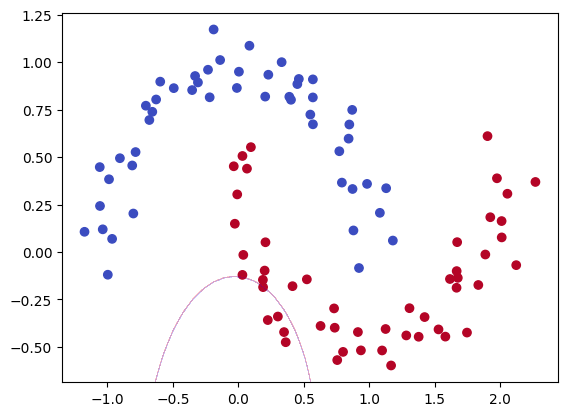

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Kernel Functions
def polynomial_kernel(x_i, x_j, c=1, n=3):
    """Polynomial kernel function."""
    return (np.dot(x_i, x_j) + c) ** n

def rbf_kernel(x_i, x_j, gamma=0.1):
    """Radial Basis Function (RBF) kernel."""
    distance = np.linalg.norm(x_i - x_j) ** 2
    return np.exp(-gamma * distance)

# Prediction Function
def predict(alpha_i, b, x, kernel, **kwargs):
    """Predict the class label for a single sample x using the specified kernel."""
    sum = 0
    for i in range(len(X)):
        sum += alpha_i[i] * Y[i] * kernel(X[i], x, **kwargs)
    return sum + b

# Generating a Non-linearly Separable Dataset
X, labels = make_moons(n_samples=100, noise=0.1, random_state=42)
Y = np.where(labels == 0, -1, 1)  

# SVM-like Training Loop
def train_svm(kernel, **kernel_params):
    alpha_i = np.zeros(len(X))
    b = 0
    epochs = 100
    learning_rate = 0.1
    
    for epoch in range(epochs):
        for i in range(len(X)):
            x, y = X[i], Y[i]
            if y * predict(alpha_i, b, x, kernel, **kernel_params) <= 0:
                alpha_i[i] += learning_rate * y
                b += learning_rate * y
    return alpha_i, b

# Visualization
def plot_decision_boundary(kernel, **kernel_params):
    alpha_i, b = train_svm(kernel, **kernel_params)
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.coolwarm)
    
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    
    Z = np.zeros_like(xx)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            Z[i, j] = predict(alpha_i, b, [xx[i, j], yy[i, j]], kernel, **kernel_params)
    
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.2, colors=['blue', 'red', 'blue'])
    plt.show()

plot_decision_boundary(polynomial_kernel, c=1, n=3)




b) Assume we fit an SVM using a polynomial Kernel function and it seems to overfit the data. How would you adjust the tuning parameter `n` of the kernel function?

To combat overfitting in an SVM with a polynomial kernel, consider lowering the degree (n) of the kernel to simplify the model and enhance its ability to generalize. Additionally, adjusting the regularization parameter (C), ensuring feature scaling, and using cross-validation for systematic hyperparameter tuning can also help. If overfitting persists, exploring alternative kernels like the radial basis function (RBF) may offer better performance. These strategies aim to strike a balance between the model's complexity and its generalization capabilities, thereby mitigating overfitting.

c) Assume we fit an SVM using a RBF Kernel function and it seems to underfit the data. How would you adjust the tuning parameter `sigma` of the kernel function?

To address underfitting in an SVM using an RBF kernel, you can adjust the γ parameter (inversely related to σ) to increase the model's sensitivity to the training data, thereby enhancing its complexity and ability to capture intricate patterns. A higher γ value results in a decision boundary that is better fitted to the nuances of the training data. Alongside adjusting γ, reducing the regularization parameter (C) and performing feature engineering may also help in improving the model fit. Employing cross-validation for systematic hyperparameter tuning ensures the selection of an optimal model configuration that effectively balances complexity and generalization, reducing underfitting without veering into overfitting.

d) Tune the parameter of a specific Kernel function, to fit an SVM (using your code above) to the following dataset:

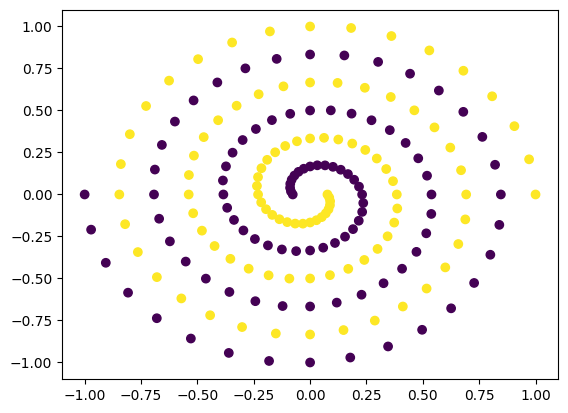

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("spiral.data")
x, y = data[:, :2], data[:, 2]

plt.scatter(x[:,0], x[:,1], c=y)

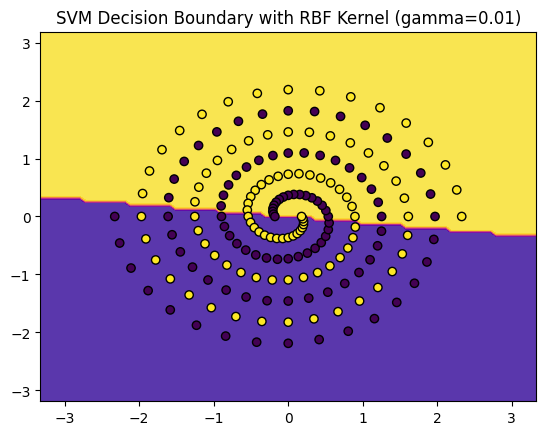

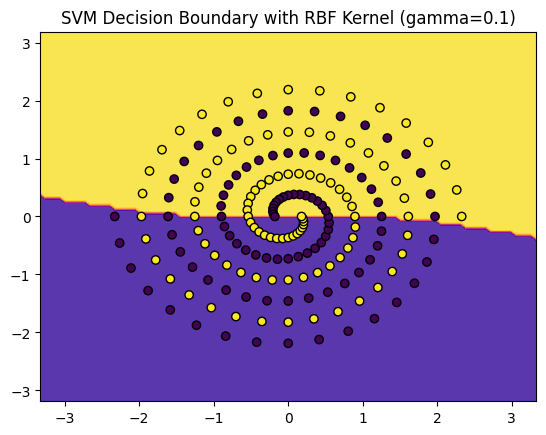

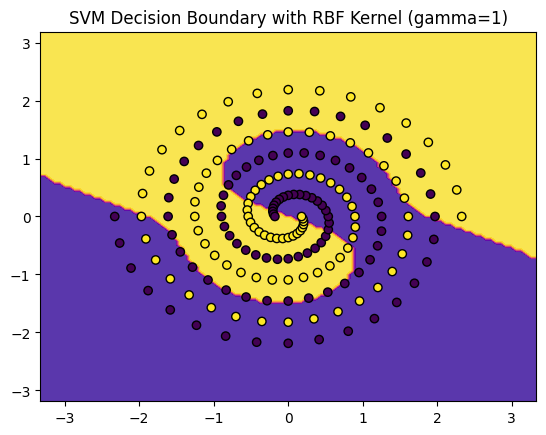

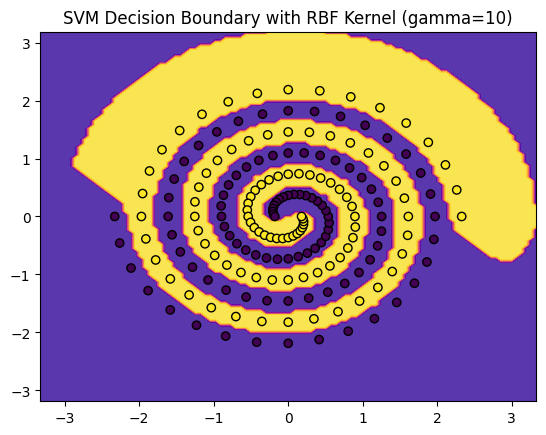

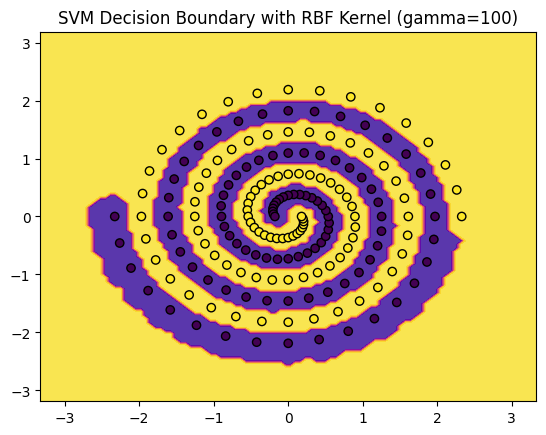

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = np.loadtxt("spiral.data")
X, y = data[:, :2], data[:, 2]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Values of gamma to try
gamma_values = [0.01, 0.1, 1, 10, 100]

# Fit the SVM model with RBF kernel for different values of gamma
for gamma in gamma_values:
    svc = SVC(kernel='rbf', gamma=gamma).fit(X_scaled, y)

    # Visualize the decision boundary
    x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
    y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Evaluate the classifier on all the grid points
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.plasma, alpha=0.8)

    # Plot also the training points
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=plt.cm.viridis, edgecolors='k')
    plt.title(f'SVM Decision Boundary with RBF Kernel (gamma={gamma})')
    plt.show()
